# Estimating 3D rotation from 2D images

In this notebook I prototype and generate test images to explore this idea.

In [2]:
import numpy as np
import cv2

R_sphere = 1 # Sphere radius
N = 10 # No:of test points generated
omega = 0.0255 # Rotation speed is s^-1
p = np.array( [-0.61291544,  0.79014699, -0.00154731], dtype = 'float32') # Orientation of rotation axis

p = p/np.linalg.norm(p)  # Unit vector

# Initial locations of the points
theta = np.random.uniform(0, 2*np.pi, N)
r = np.random.uniform(0,R_sphere,N)

x_init, z_init = r*np.cos(theta), r*np.sin(theta) 
y_init = (R_sphere**2 - x_init**2 - z_init**2)**(1/2)  # Only assuming points in the +ve y direction

r_init = np.stack((x_init, y_init, z_init))

np.shape(r_init)

(3, 10)

<IPython.core.display.Javascript object>


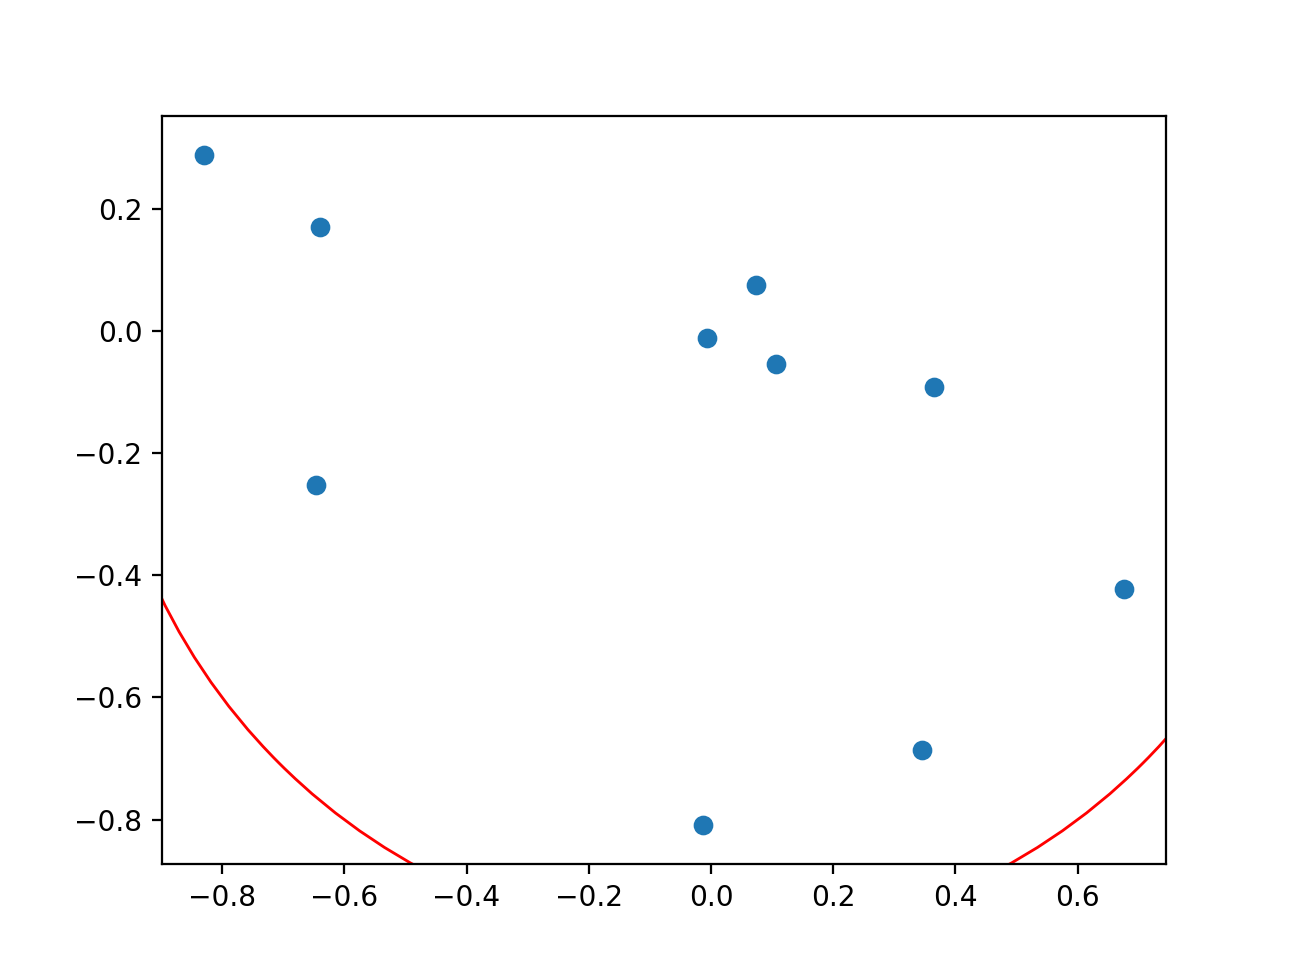

In [3]:
# Plot the initial distribution of points within the circle
import matplotlib.pyplot as plt
%matplotlib notebook
plt.figure()
plt.scatter(r_init[0,:], r_init[2,:])
ax = plt.gca()
circle1 = plt.Circle((0, 0), 1, fill= False, color='r')
ax.add_artist(circle1)
plt.axis('equal')
plt.show()

In [4]:
# Simulate the trajectory of points under solid-body rotation.
# using v = \omega \cross r

omega_vector = omega*p

v = np.cross(omega_vector, r_init, axisa = 0, axisb = 0)
v

array([[-0.00182269, -0.00145662, -0.02183522],
       [-0.00504642, -0.00391102,  0.00177459],
       [ 0.00582909,  0.0045397 ,  0.00923253],
       [-0.01380587, -0.01074238, -0.01695045],
       [-0.00847328, -0.00661787, -0.02306602],
       [ 0.00153647,  0.00115846, -0.01704182],
       [-0.01627412, -0.01264127, -0.00891893],
       [-0.00104664, -0.00084647, -0.0176643 ],
       [-0.00020854, -0.00019213, -0.01550537],
       [ 0.00346793,  0.00269234,  0.00115943]])

<IPython.core.display.Javascript object>


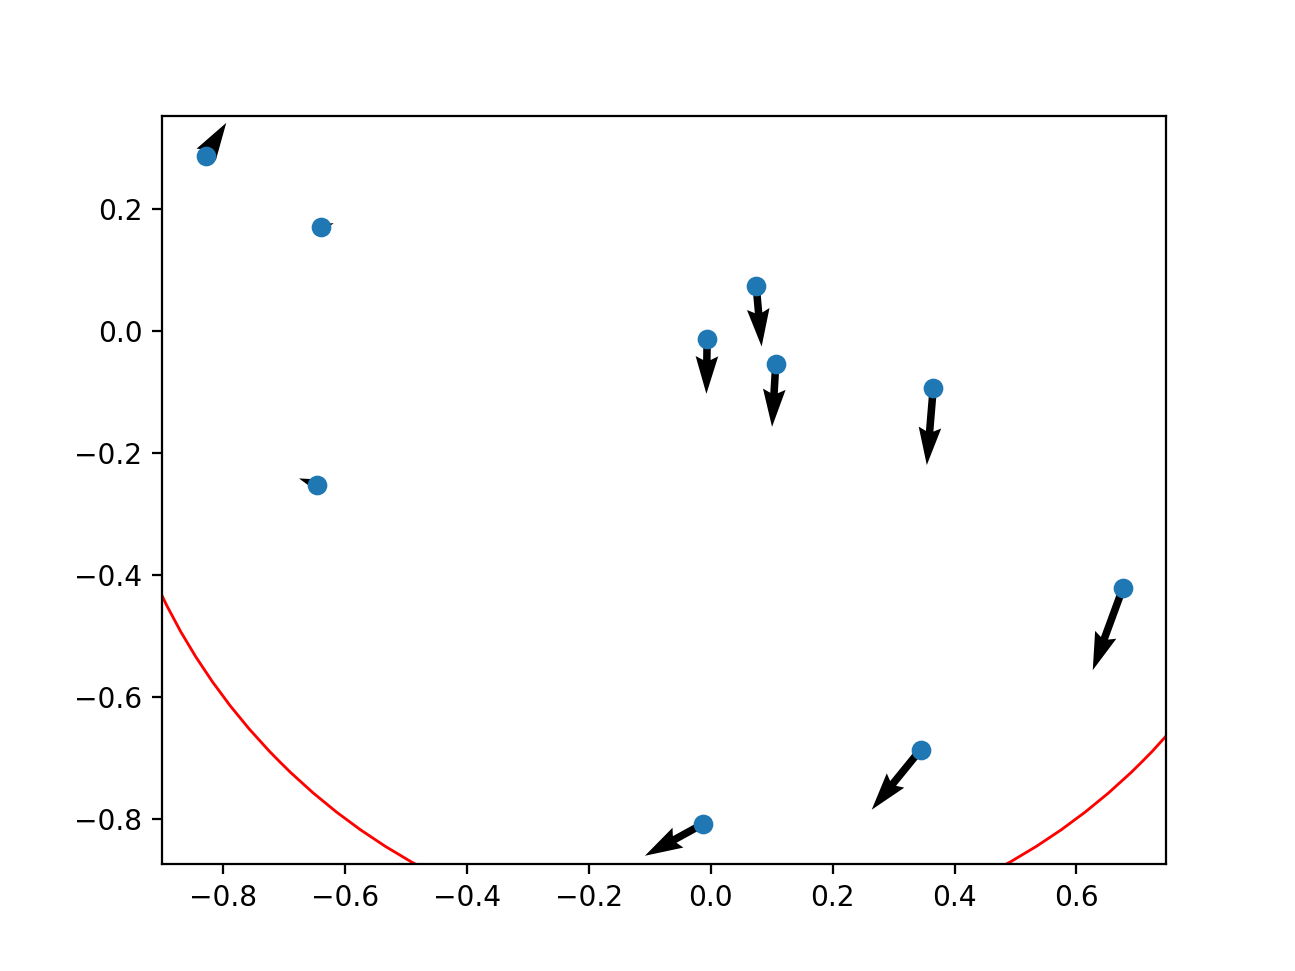

In [5]:
plt.figure()
plt.quiver(r_init[0,:], r_init[2,:], v[:,0], v[:,2])
plt.scatter(r_init[0,:], r_init[2,:])
ax = plt.gca()
circle1 = plt.Circle((0, 0), 1, fill= False, color='r')
ax.add_artist(circle1)
plt.axis('equal')
plt.show()

In [6]:
from scipy.spatial.transform import Rotation as R

r = R.from_rotvec(omega*p)

r.as_matrix

<bound method Rotation.as_matrix of <scipy.spatial.transform.rotation.Rotation object at 0x00000146EAC17DD8>>

In [7]:
# Create a trajectory of surface points over time

N_timesteps = 50

# Create image canvas
image_size = (640, 640)
R_circle = int(0.7*image_size[0]/2)
center = (320, 320)

init_image = np.random.randint(50, size = (640,640), dtype = np.uint8)

cv2.circle(init_image, center, R_circle ,(150,0,0),-1)

plt.figure()
plt.imshow(image, cmap = 'gray', vmin = 0, vmax = 255)
plt.show()



<IPython.core.display.Javascript object>

NameError: name 'image' is not defined

In [8]:
# Make some test images with simulated surface features and their dynamics over time
import os
from datetime import datetime

save_folder = 'C:/Users/Deepak/Dropbox/ActiveMassTransport_Vorticella_SinkingAggregates/RotationalAnalysis/test_images_' + datetime.now().strftime('%Y-%m-%d %H-%M')

if(not os.path.exists(save_folder)):
    os.makedirs(save_folder)
    
    
prev_pos = r_init
curr_pos = np.zeros_like(prev_pos) 
for ii in range(N_timesteps):
    
    image = np.copy(init_image)
    # We need to transform to spherical coordinates to do this (otherwise, we will no longer be on the sphere)
    for jj in range(N):
        curr_pos[:,jj] = r.apply(prev_pos[:,jj])
        # Add some Gaussian noise to the positions
#         noise = (0.001)*np.random.randn(3)
        noise = 0
        curr_pos[:,jj] = curr_pos[:,jj] + noise
        feature_loc = (center[0] + int(R_circle*curr_pos[0,jj]), center[1] + int(R_circle*curr_pos[2,jj]))
        cv2.circle(image, feature_loc, int(0.01*image_size[0]),(225,0,0),-1)
    
    cv2.imwrite(os.path.join(save_folder, 'test_image_{:03d}.tif'.format(ii)), image)
#     plt.figure()
#     plt.imshow(image, cmap = 'gray', vmin = 0, vmax = 255)
#     plt.show()
        
    prev_pos = curr_pos
    

# Save the rotation rate and axis 
import pandas as pd

df = pd.DataFrame({'Omega':[omega], 'p_x':[p[0]], 'p_y':[p[1]], 'p_z':[p[2]]})

df.to_csv(os.path.join(save_folder,'RotationParameters.csv'))

(190, 259)
(209, 240)
(443, 305)
(297, 114)
(416, 370)
(199, 426)
(410, 329)
(422, 258)
(352, 521)
(406, 320)


<IPython.core.display.Javascript object>


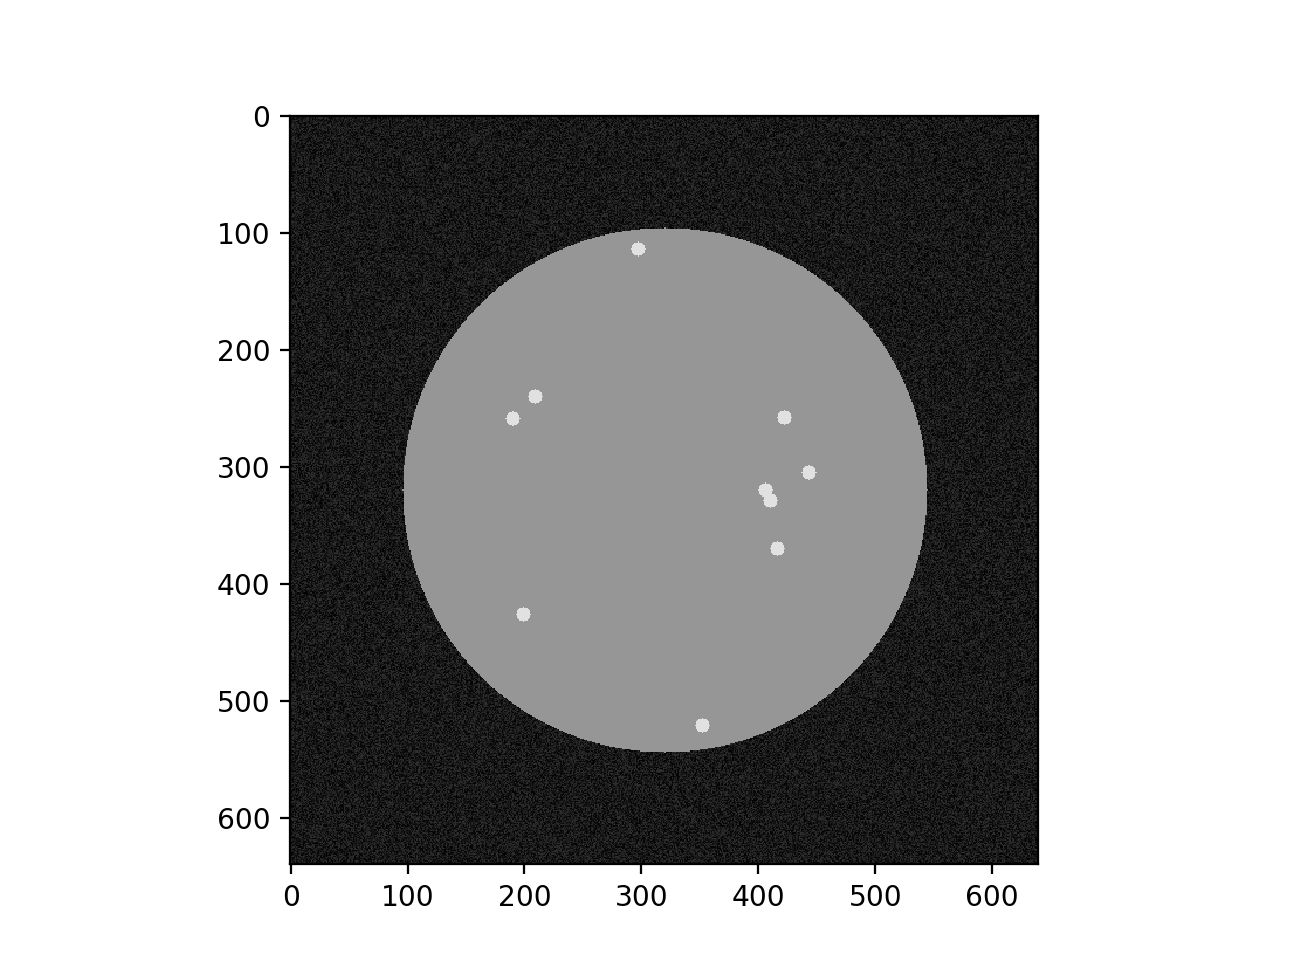

In [182]:

image = np.copy(init_image)
for jj in range(N):
    feature_loc = (center[0] + int(R_circle*curr_pos[0,jj]), center[1] + int(R_circle*curr_pos[2,jj]))
    print(feature_loc)
    cv2.circle(image, feature_loc, int(0.01*image_size[0]),(225,0,0),-1)

plt.figure()
plt.imshow(image, cmap = 'gray', vmin = 0, vmax = 255)
plt.show()

[[-7.92485533e-01 -8.13973181e-01 -8.01161513e-01 -3.83511766e-01
  -8.51330766e-01 -7.19167248e-01 -8.92055954e-01 -8.19233786e-01
  -4.03229407e-01 -9.01026891e-01]
 [ 5.43845102e-01  4.57064700e-01 -5.94266200e-01  8.44075527e-02
  -4.72700797e-01  5.06010685e-01 -4.50052250e-01 -4.99883339e-01
  -1.67299443e-01 -4.33763003e-01]
 [-2.76042000e-01 -3.58524087e-01 -7.06251561e-02 -9.19670642e-01
   2.27573909e-01  4.76184477e-01  4.10992413e-02 -2.81020730e-01
   8.99676020e-01 -4.44697748e-04]]
[[-7.92485533e-01 -8.13973181e-01 -8.01161513e-01 -3.83511766e-01
  -8.51330766e-01 -7.19167248e-01 -8.92055954e-01 -8.19233786e-01
  -4.03229407e-01 -9.01026891e-01]
 [ 5.43845102e-01  4.57064700e-01 -5.94266200e-01  8.44075527e-02
  -4.72700797e-01  5.06010685e-01 -4.50052250e-01 -4.99883339e-01
  -1.67299443e-01 -4.33763003e-01]
 [-2.76042000e-01 -3.58524087e-01 -7.06251561e-02 -9.19670642e-01
   2.27573909e-01  4.76184477e-01  4.10992413e-02 -2.81020730e-01
   8.99676020e-01 -4.44697748e-0

<IPython.core.display.Javascript object>


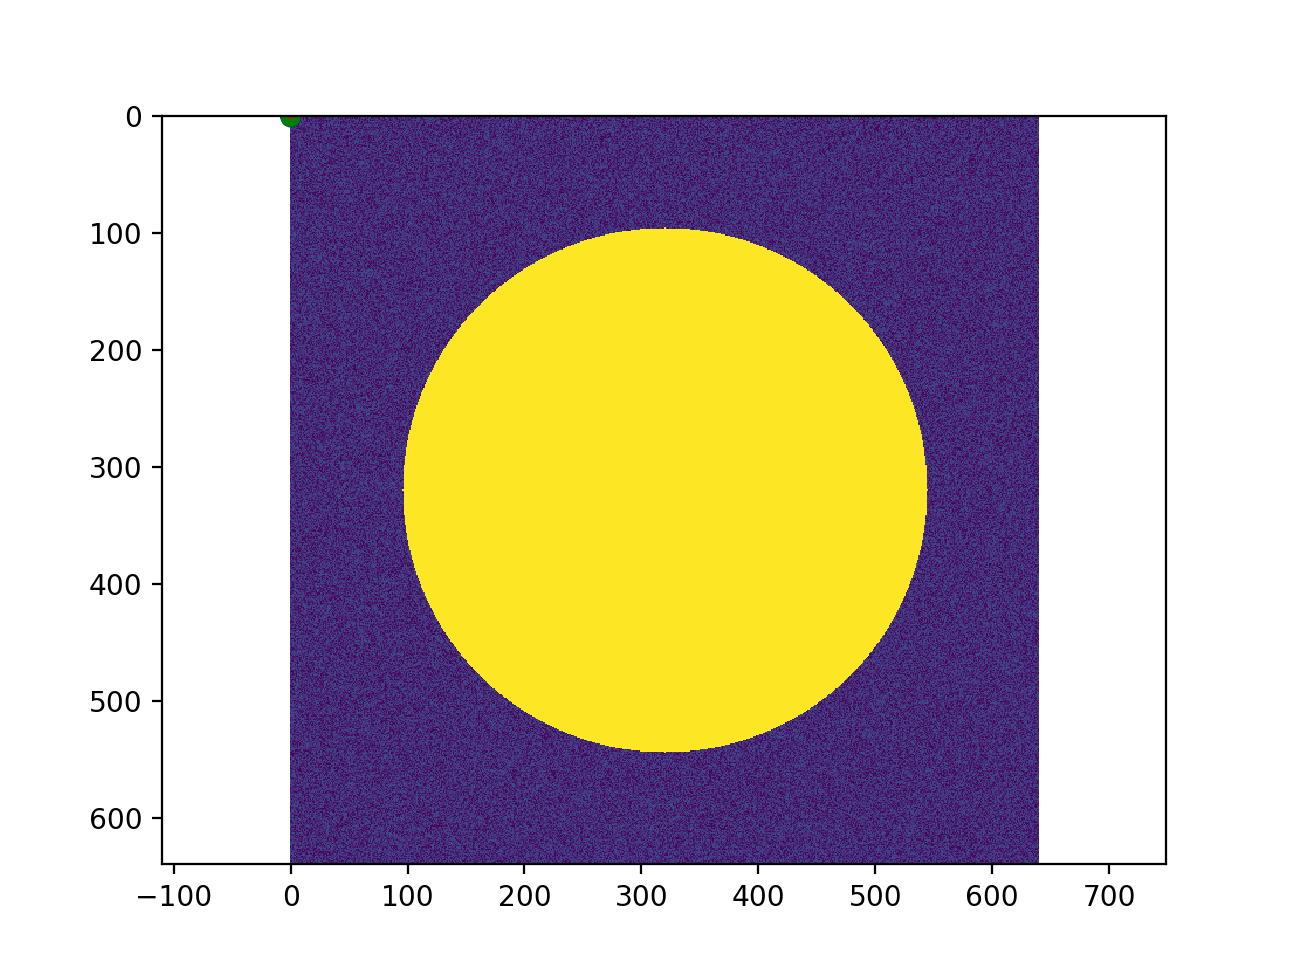

In [149]:
    

print(curr_pos)
print(next_pos)

plt.figure()
plt.scatter(curr_pos[0,:], curr_pos[2,:], color = 'b', alpha = 0.5)
plt.scatter(next_pos[0,:], next_pos[2,:], color = 'g', alpha = 0.5)
circle1 = plt.Circle((0, 0), 1, fill= False, color='r')
ax1 = plt.gca()
ax1.add_artist(circle1)

plt.axis('equal')
plt.show()
    


In [156]:
pos_array

{0: array([[-8.78174728e-01, -8.15474356e-01,  8.70783164e-02,
         -2.72641360e-01, -4.27654170e-02, -8.07563423e-01,
         -8.33786029e-02, -2.80448837e-03, -6.84793550e-02,
         -1.01953884e-01],
        [-3.90653250e-01, -4.54380957e-01, -9.93694850e-01,
         -2.82617407e-01, -9.72821276e-01, -3.47979400e-01,
         -9.95670056e-01, -9.59697600e-01, -4.31153843e-01,
         -9.94789027e-01],
        [-2.76042000e-01, -3.58524087e-01, -7.06251561e-02,
         -9.19670642e-01,  2.27573909e-01,  4.76184477e-01,
          4.10992413e-02, -2.81020730e-01,  8.99676020e-01,
         -4.44697748e-04]]),
 1: array([[-8.78174728e-01, -8.15474356e-01,  8.70783164e-02,
         -2.72641360e-01, -4.27654170e-02, -8.07563423e-01,
         -8.33786029e-02, -2.80448837e-03, -6.84793550e-02,
         -1.01953884e-01],
        [-3.90653250e-01, -4.54380957e-01, -9.93694850e-01,
         -2.82617407e-01, -9.72821276e-01, -3.47979400e-01,
         -9.95670056e-01, -9.59697600e-01, -

In [240]:
pos_array

{0: array([[-5.83381691e-01, -4.97804248e-01,  5.52821091e-01,
         -1.03771304e-01,  4.28865170e-01, -5.41873374e-01,
          4.04178035e-01,  4.57642359e-01,  1.46609871e-01,
          3.87454304e-01],
        [-7.63849866e-01, -7.89716031e-01, -8.30301709e-01,
         -3.78731338e-01, -8.74233826e-01, -6.92547176e-01,
         -9.13756515e-01, -8.43558427e-01, -4.11203848e-01,
         -9.21888803e-01],
        [-2.76042000e-01, -3.58524087e-01, -7.06251561e-02,
         -9.19670642e-01,  2.27573909e-01,  4.76184477e-01,
          4.10992413e-02, -2.81020730e-01,  8.99676020e-01,
         -4.44697748e-04]]),
 1: array([[-5.83381691e-01, -4.97804248e-01,  5.52821091e-01,
         -1.03771304e-01,  4.28865170e-01, -5.41873374e-01,
          4.04178035e-01,  4.57642359e-01,  1.46609871e-01,
          3.87454304e-01],
        [-7.63849866e-01, -7.89716031e-01, -8.30301709e-01,
         -3.78731338e-01, -8.74233826e-01, -6.92547176e-01,
         -9.13756515e-01, -8.43558427e-01, -

<IPython.core.display.Javascript object>


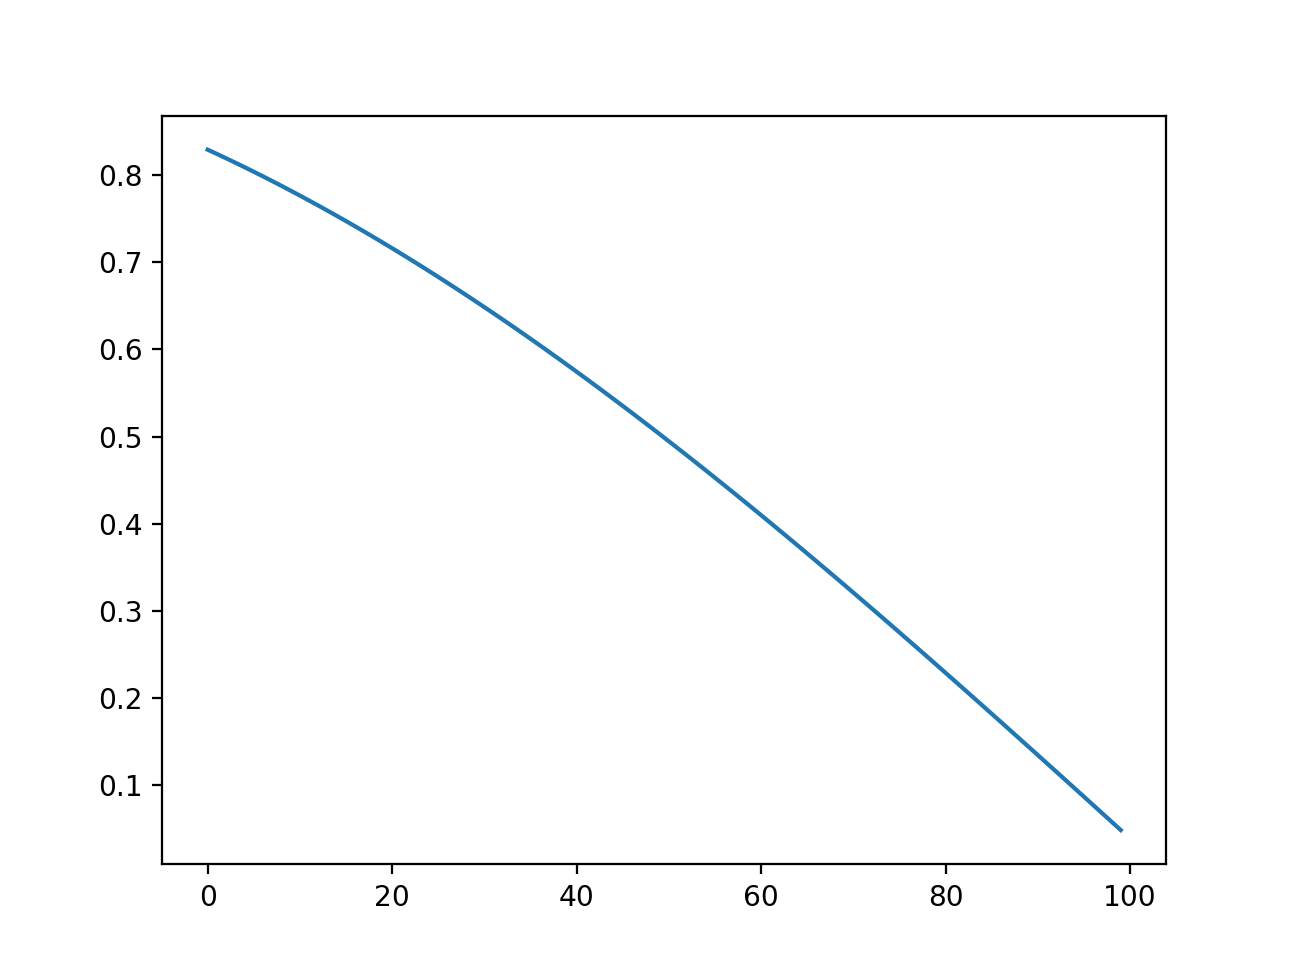

In [160]:
pos_array

{0: array([[-5.83381691e-01, -4.97804248e-01,  5.52821091e-01,
         -1.03771304e-01,  4.28865170e-01, -5.41873374e-01,
          4.04178035e-01,  4.57642359e-01,  1.46609871e-01,
          3.87454304e-01],
        [-7.63849866e-01, -7.89716031e-01, -8.30301709e-01,
         -3.78731338e-01, -8.74233826e-01, -6.92547176e-01,
         -9.13756515e-01, -8.43558427e-01, -4.11203848e-01,
         -9.21888803e-01],
        [-2.76042000e-01, -3.58524087e-01, -7.06251561e-02,
         -9.19670642e-01,  2.27573909e-01,  4.76184477e-01,
          4.10992413e-02, -2.81020730e-01,  8.99676020e-01,
         -4.44697748e-04]]),
 1: array([[-5.83381691e-01, -4.97804248e-01,  5.52821091e-01,
         -1.03771304e-01,  4.28865170e-01, -5.41873374e-01,
          4.04178035e-01,  4.57642359e-01,  1.46609871e-01,
          3.87454304e-01],
        [-7.63849866e-01, -7.89716031e-01, -8.30301709e-01,
         -3.78731338e-01, -8.74233826e-01, -6.92547176e-01,
         -9.13756515e-01, -8.43558427e-01, -

array(<bound method Rotation.as_matrix of <scipy.spatial.transform.rotation.Rotation object at 0x000002786E8E35F8>>,
      dtype=object)

array([0.70710677, 0.7071068 , 0.        ])